# Imports

In [1]:
import sys
import copy
import rospy
import moveit_commander
import moveit_msgs.msg
import geometry_msgs.msg
import time
import open_manipulator_msgs.msg
from math import pi
from std_msgs.msg import String
from moveit_commander.conversions import pose_to_list
from open_manipulator_msgs.srv import *

! pip install pyrealsense2
import pyrealsense2 as rs
import numpy as np
import cv2
import time
import math

#import all the libraries
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import os
import PIL
import glob

#First neural network (is there a digit on the picture taken?)

In [2]:
class MLPDecider(nn.Module):
    
  def __init__(self):
    super(MLPDecider, self).__init__()
    self.lin1=nn.Linear(28*28, 300)
    self.lin2=nn.Linear(300, 80)
    self.lin3=nn.Linear(80, 10)
    self.lin4=nn.Linear(10, 2)
    self.dropout = nn.Dropout(0.3)
    self.batchn=nn.BatchNorm2d(1)
        
  def forward(self, x):
        
    temp=x
    temp=self.batchn(temp)
    temp=self.dropout(temp)
    temp=temp.view((temp.shape[0], 28*28))
    temp=self.lin1(temp)
    temp=F.relu(temp)
    temp=self.lin2(temp)
    temp=F.relu(temp)
    temp=self.lin3(temp)
    temp=F.relu(temp)
    temp=self.lin4(temp)
    out=temp
       
    return out

def loadMLP():
  net=MLPDecider()
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  net.to(device)
  num_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
  NetData=torch.load('MLPDeciderData.pth', map_location=torch.device('cpu')) #the file is in the public google drive, Code section. If you dont finf it ask Richard, he has it on his notebook as well
  net.load_state_dict(NetData)
  net.eval()
  return net

In [3]:
def DigitOrNot(image):
  '''input: a 28*28 torch tensor'''
  image=image.view(1, 1, 28, 28) #nn needs this 
  net=loadMLP()
  out=net.forward(image)
  pred=torch.argmax(out)
  if pred==0:
    print("Waiting for a number! Insert Object!")
    return False
  elif pred==1:
    print("Found number!")
    return True

# Convolutional Neural Network (digit recognition)

In [27]:
# Define the neuronal network
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    #784
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)                  
    self.pool = nn.MaxPool2d(kernel_size=2)
    self.conv2 = nn.Conv2d(16, 32, 5, 1, 2)
    self.fc1 = nn.Linear(32 * 7 * 7, 400) 
    self.fc2 = nn.Linear(400, 200)
    self.fc3 = nn.Linear(200, 10)
    self.drop = nn.Dropout(p=0.5)
    self.batchn = nn.BatchNorm2d(32)

  def forward(self, x):
    out = self.pool(F.relu(self.conv1(x)))
    out = self.pool(F.relu(self.conv2(out)))
    out = self.batchn(out)
    out = self.drop(out)
    out = out.view(-1,32*7*7)
    out = F.relu(self.fc1(out))
    out = F.relu(self.fc2(out))
    out = self.fc3(out)   
    

    return out

#load the trained network. The command: Netdata=torch.load('MNISTCNNcheckpoint.pth', map_location=torch.device('cpu')) 
#is where you select the file with the data you wanna load. Make sure the file has the name it has in the command and is in the same folder as this program
#I uploaded the file I used in this code, it is from the MNIST CNN in the dropbox. I only trained for 3 epochs, feel free to you use you own longer trained one!

net = CNN()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
Netdata=torch.load('CNNMNIST2.pth', map_location=torch.device('cpu'))
net.load_state_dict(Netdata)
net.eval


def runCNN(imageMatrix):
  out=net.forward(imageMatrix) #calculating the output
  out=torch.argmax(out) #here we check which number the network actually predicted
  return int(out)

# Detect with camera


In [35]:
def captureImage():

    pipeline = rs.pipeline()
    config = rs.config()

    config.enable_stream(rs.stream.depth, 1280, 720, rs.format.z16, 6)
    config.enable_stream(rs.stream.color, 1280, 720, rs.format.bgr8, 6)

    profile = pipeline.start(config)
    depth_sensor = profile.get_device().first_depth_sensor()
    depth_scale = depth_sensor.get_depth_scale()

    # We will be removing the background of objects more than
    #  clipping_distance_in_meters meters away
    clipping_distance_in_meters = 1.5 
    clipping_distance = clipping_distance_in_meters / depth_scale

    align_to = rs.stream.color
    align = rs.align(align_to)

    frames = pipeline.wait_for_frames()

    aligned_frames = align.process(frames)
    aligned_depth_frame = aligned_frames.get_depth_frame()
    color_frame = aligned_frames.get_color_frame()

    color_image = np.asanyarray(color_frame.get_data())

    """
    # Other functionalities that we do not use (3D images...)
    depth_image = np.asanyarray(aligned_depth_frame.get_data())
    # Remove background - Set pixels further than clipping_distance to grey
    grey_color = 153
    depth_image_3d = np.dstack((depth_image,depth_image,depth_image)) #depth image is 1 channel, color is 3 channels
    bg_removed = np.where((depth_image_3d > clipping_distance) | (depth_image_3d <= 0), grey_color, color_image)
    # Render images
    depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.03), cv2.COLORMAP_JET)
    images = np.hstack((bg_removed, depth_colormap))
    cv2.namedWindow('Align Example', cv2.WINDOW_AUTOSIZE)
    """
    # Filename 
    imageName1 = './pics/realsense' + str(time.strftime("%Y_%m_%d_%H_%M_%S")) +  '_Color.jpg'

    # Saving the image 
    cv2.imwrite(imageName1, color_image) 
    print(imageName1)

    key = cv2.waitKey(1)
    # Press esc or 'q' to close the image window
    cv2.destroyAllWindows()

    pipeline.stop()
    return color_image

## Image processing

In [29]:
def image_processing(image):

    cv2.resize(image, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)

    #show the picture taken
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(image)

    image = cv2.medianBlur(image,5)
    grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image=grayImage

    #image=blackAndWhiteImage

    # This part only is for visualization purpose, thresholds comparison
    ret,th1 = cv2.threshold(image,127,255,cv2.THRESH_BINARY)
    #image = th1

    th2 = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
                cv2.THRESH_BINARY,11,2)

    th3 = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
                cv2.THRESH_BINARY,11,2)
    titles = ['Original Image', 'Global Thresholding (v = 127)',
                'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
    images = [image, th1, th2, th3]
    for i in range(4):
        plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
        plt.title(titles[i])
        plt.xticks([]),plt.yticks([])

    print(image.shape)
    # We choose the Gaussian thresholding
    image = th1
    image = cv2.bitwise_not(image)

    #show the entire processed picture
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(image)

    #take the part of the picture which contains the number (it just takes the hard coded coordinates regardless of the picture, cause most of the time the number is gonna be in the middle)
    tempIM=np.asarray(image)
    print(tempIM.shape)
    woIM=tempIM[0:418,0:418] #you might have to change these numbers for getting the number in. It is important that their distance is always 112. 

    #show the selected part of the image
    print(woIM.shape)
    plt.figure(figsize=(50,8))
    plt.axis('off')
    plt.imshow(woIM)

    #downscale the image
    woIMre=cv2.resize(src=woIM, dsize=(28,28))
    print(woIMre.shape)

    # Show the downscaled image
    plt.figure(figsize=(50,8))
    plt.axis('off')
    plt.imshow(woIMre)
    save=woIMre

    # Reshaping the input data so the network can process it.
    woIMre=np.reshape(woIMre, [1, 1, 28, 28])

    '''I use 255 as the norm because the tensors of the pictures my camera takes contain numbers from 0 to 255, but the CNN only works well for
    matrixes with numbers im between 0 and 1. so you might need to change this depending on you camera, just make sure the matrix immediently before you
    put into the networks does not contain numbers higher than one and no 'nan' values'''
    norm=255
    woIMre=woIMre/norm

    # Transforming the input into a pytorch datatype so the network can process it
    woIMre=torch.tensor(woIMre)
    woIMre=woIMre.float() # Network wants float, so we give it float
    return woIMre
    


In [30]:
def detectNumber():
    image_matrix = image_processing(captureImage()) # Capture and process image to matrix
    numberInImage =DigitOrNot(image_matrix) # Use perceptron to scan for number
    number = runCNN(image_matrix) #Use CNN to classify number on image
    if numberInImage: 
        print("There is an object and it seems to be labelled: ", number)
    else: print("No object...For now!")
    return numberInImage, number


# Moveit moving code

In [52]:
home = [0, -1.052, 0.354, 0.703]
init = [0, 0, 0, 0]
photo_pos = [0, 0.293, -0.8, 2]
grab_pos= [0.3, -0.1, .1, .8]
box1 = [-1.5, 0.293, -0.4, 1.5]
box2 = [1.5, 0.293, -0.4, 1.5]
returning_from_box1 = [-1.5, -.4, -0.4, 1.5]
returning_from_box2 = [1.5, -.4, -0.4, 1.5]

close_joints_in_grip = -0.01
open_joints_in_grip = 0.01


def over_position(position):
  return [position[0], position[1], position[2] - 0.3, position[3] + 0.2]
print(over_position(box2))

[1.5, 0.6, -1.5, 2.0]


In [71]:
class MoveGroupPythonInterface(object):
    def __init__(self):
        super(MoveGroupPythonInterface, self).__init__()
        ## First initialize `moveit_commander`_ and a `rospy`_ node:
        moveit_commander.roscpp_initialize(sys.argv)
        rospy.init_node('move_group_python_interface_tutorial', anonymous=True)
        ## Instantiate a `RobotCommander`_ object. Provides information such as the robot’s
        ## kinematic model and the robot’s current joint states
        robot = moveit_commander.RobotCommander()
        ## Instantiate a `PlanningSceneInterface`_ object. This provides a remote interface
        ## for getting, setting, and updating the robot’s internal understanding of the
        ## surrounding world: 
        scene = moveit_commander.PlanningSceneInterface()
        ## Instantiate a `MoveGroupCommander`_ object. This object is an interface
        ## to a planning group (group of joints). In this tutorial the group is the primary
        ## arm joints in the Panda robot, so we set the group’s name to "panda_arm".
        ## If you are using a different robot, change this value to the name of your robot
        ## arm planning group.
        ## This interface can be used to plan and execute motions:
        group_name = "arm"
        move_group = moveit_commander.MoveGroupCommander(group_name)
        ## Create a `DisplayTrajectory`_ ROS publisher which is used to display
        ## trajectories in Rviz:
        display_trajectory_publisher = rospy.Publisher('/move_group/display_planned_path',
        moveit_msgs.msg.DisplayTrajectory,
        queue_size=20)
        ##
        ## Getting Basic Information
        ## ^^^^^^^^^^^^^^^^^^^^^^^^^
        # We can get the name of the reference frame for this robot:
        planning_frame = move_group.get_planning_frame()
        print ("============ Planning frame: %s" % planning_frame)
        # We can also print the name of the end-effector link for this group:
        eef_link = move_group.get_end_effector_link()
        print ("============ End effector link: %s" % eef_link)
        # We can get a list of all the groups in the robot:
        group_names = robot.get_group_names()
        print ("============ Available Planning Groups:", robot.get_group_names())
        # Sometimes for debugging it is useful to print the entire state of the
        # robot:
        print ("============ Printing robot state")
        print (robot.get_current_state())
        print ("")
        # Misc variables
        self.box_name = ""
        self.robot = robot
        self.scene = scene
        self.move_group = move_group
        self.display_trajectory_publisher = display_trajectory_publisher
        self.planning_frame = planning_frame
        self.eef_link = eef_link
        self.group_names = group_names

    def move(self, joint_goal):
        move_group = self.move_group
        move_group.go(joint_goal, wait=True)
        # Calling ``stop()`` ensures that there is no residual movement
        move_group.stop()
        time.sleep(3.5)
        return 0

    def control_grapper(self, joint_value):
        rospy.wait_for_service('/open_manipulator/goal_tool_control')
        set_joint_position = rospy.ServiceProxy('/open_manipulator/goal_tool_control', SetJointPosition)
        msg = open_manipulator_msgs.msg.JointPosition()
        msg.joint_name.append("gripper")
        msg.position.append(joint_value)
        resp1 = set_joint_position("arm", msg, 5)
        time.sleep(1.5)

In [76]:
def reposition(number, MoveGroupInterface):
  MoveGroupInterface.move(grab_pos) #arm repositions with respect to the object

  if number%2 == 0:
    drop_pos = box1
    over_drop = returning_from_box1
  else:
    drop_pos = box2
    over_drop = returning_from_box2
  MoveGroupInterface.move(home)
  MoveGroupInterface.move(over_drop)
  MoveGroupInterface.move(drop_pos)  #computes path to the number´s placement position
  #moveGroup.control_grapper(open_joints_in_grip) #releases the object
  # move robot away from object slightly
  
  #moveGroup.move(get_joints_reverse_move(number)) #reset to starting position


# Run robot

In [77]:
def main():
  try:
    MoveGroupInterface = MoveGroupPythonInterface()
    while(True):
      MoveGroupInterface.move_simple(photo_pos)
      numberInImage, number = detectNumber()
      if numberInImage:
        MoveGroupInterface.move(grab_pos) #arm repositions with respect to the object

        reposition(number, MoveGroupInterface)

  except rospy.ROSInterruptException:
      return "ROS interrupt"
  except KeyboardInterrupt:
      return "Keyboard interrupt"


============ Planning frame: world[ INFO] [1669908331.052522273]: Ready to take commands for planning group arm.

============ End effector link: end_effector_link
============ Available Planning Groups: ['arm', 'gripper']
============ Printing robot state
joint_state: 
  header: 
    seq: 0
    stamp: 
      secs: 0
      nsecs:         0
    frame_id: "world"
  name: 
    - joint1
    - joint2
    - joint3
    - joint4
    - gripper
    - gripper_sub
  position: [0.0, -1.0431069135665894, 0.3666214048862457, 0.7163690328598022, 0.004428091446558634, 0.004428091446558634]
  velocity: []
  effort: []
multi_dof_joint_state: 
  header: 
    seq: 0
    stamp: 
      secs: 0
      nsecs:         0
    frame_id: "world"
  joint_names: []
  transforms: []
  twist: []
  wrench: []
attached_collision_objects: []
is_diff: False

./pics/realsense2022_12_02_00_25_39_Color.jpg
(720, 1280)
(720, 1280)
(418, 418)
(28, 28)
Found number!
There is an object and it seems to be labelled:  7
hola


/tmp/ipykernel_184826/3733280056.py:29: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')


MoveItCommanderException: Error setting joint target. Is the target within bounds?

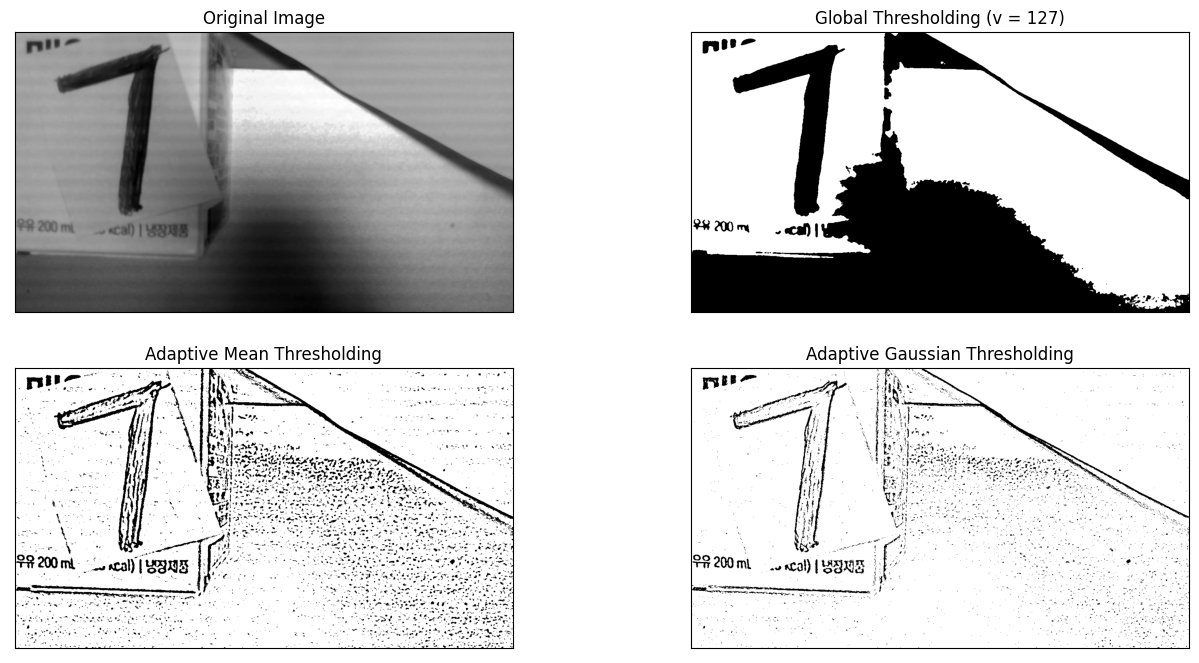

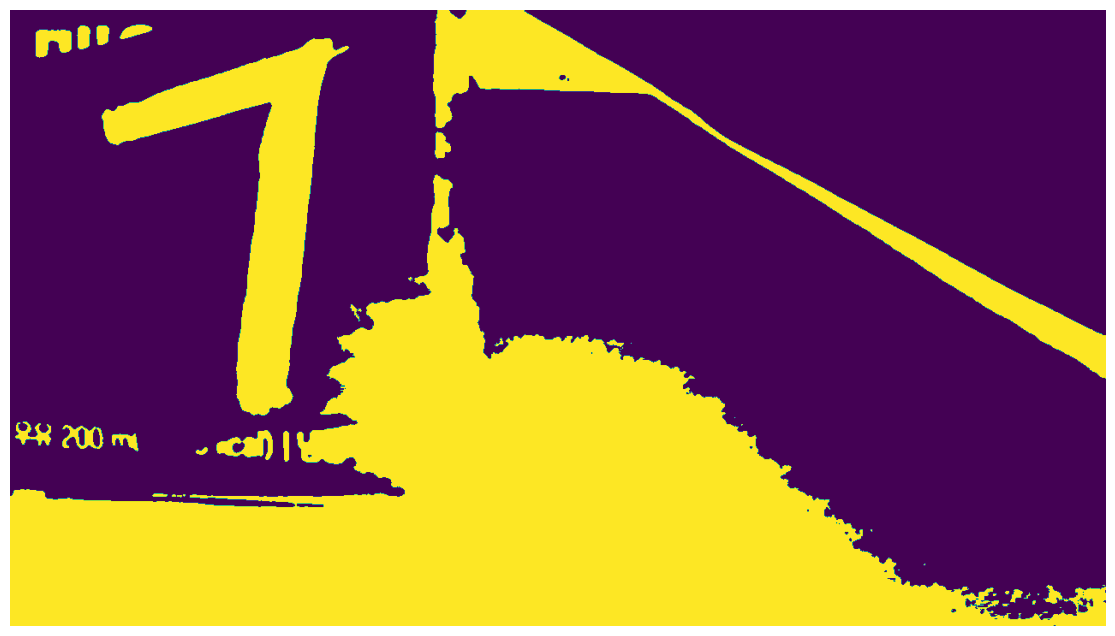

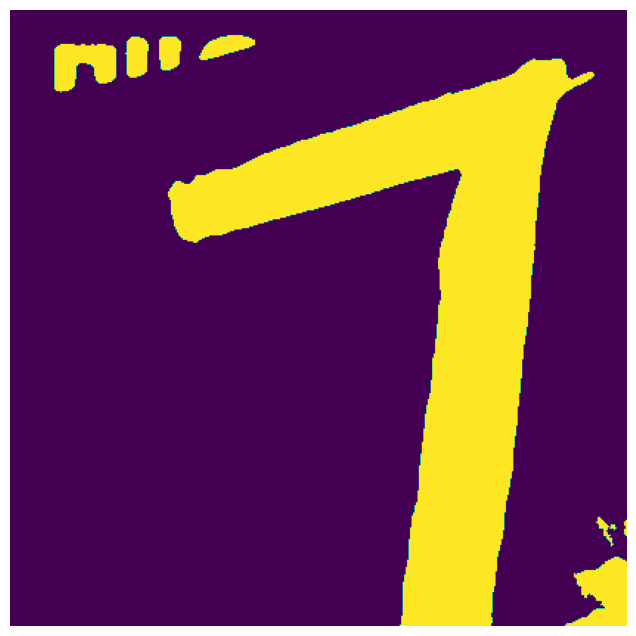

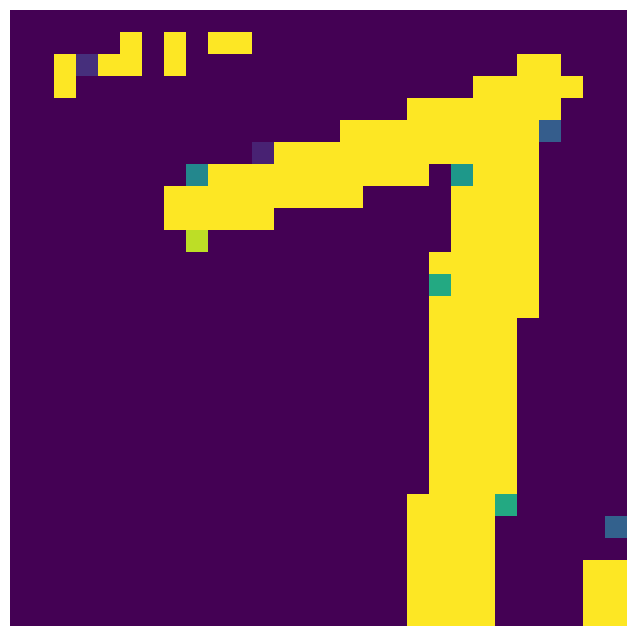

In [78]:
main()